# K-Nearest Neighbors Homework Solutions
***
**Name**: $<$insert name here$>$ 
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [2]:
import unittest
import numpy as np
from sklearn.neighbors import BallTree
import pickle, gzip
import random

class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set
        
        print(len(self.train_x)) #Number of example in training set: 50,000
        print(len(self.test_x)) #Number of examples in test set = 10,000
        print(len(self.test_x[0])) #Number of pixels = 784

In [3]:
data = Numbers("../data/mnist.pklz")

50000
10000
784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [4]:
import unittest
import numpy as np
from sklearn.neighbors import BallTree
import pickle, gzip
import random

class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        dictionary = { }
        for labels in self._y:
            if labels not in dictionary:
                dictionary[labels] = 0
            dictionary[labels] += 1

        return dictionary

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        
        neighbor_labels = [self._y[i] for i in neighbor_indices] #given indices, grab the corresponding labels from self._y
        
        labels_frequency = { }
        for labels in neighbor_labels:
            if labels not in labels_frequency:
                labels_frequency[labels] = 0
            labels_frequency[labels] += 1
            
        maximum = max(labels_frequency, key = labels_frequency.get)
        maximum_label = 0

        if labels_frequency[maximum] == 1:
            for x in labels_frequency:
                if self._counts[x] > maximum_label:
                    maximum_label = self._counts[x]
                    maximum = x

        return maximum
    

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        
        dist, ind = self._kdtree.query(np.array(example).reshape(1, -1), k=self._k)
        return self.majority(ind[0])


    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """
        
        C = np.zeros((10,10), dtype=int)
        for xx, yy in zip(test_x, test_y):
            jj = self.classify(xx) #return the predicted label
            C[yy][jj] += 1 #increase by 1 where true label and predicted label intersect 
        
        return C 
            
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        
        return np.sum(C.diagonal()) / C.sum()
        

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [5]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [ ]:
'''
The higher the number of training examples the higher the accuracy, which is valid because there are more examples 
included which allows our programs to draw more accurate conclusions when classifying images. For instance, if the number of 
training examples were only 5, then classifying an image based on a small data size results in a high chance of error. Whereas
if my training examples were 100, then classifying an image will be more accurate.

It is important to note that k = 3 gave an overall higher accuracy for corresponding data sizes with k = 2, which will be 
explored further in part B below.

Running the code below, will plot a line graph from 1000 to 10,000 data size with an increment of 1000 for both k = 2 and k = 3.
'''

In [6]:
import unittest
import numpy as np
from sklearn.neighbors import BallTree
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pickle, gzip
import random
from collections import Counter

class Numbers:
    def __init__(self, location):
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

class Knearest:
    """
    kNN classifier
    """
    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance
        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self): 
        dictionary = { }
        for labels in self._y:
            if labels not in dictionary:
                dictionary[labels] = 0
            dictionary[labels] += 1

        return dictionary

    def majority(self, neighbor_indices):
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"

        neighbor_labels = [self._y[i] for i in neighbor_indices] #given indices, grab the corresponding labels from self._y
        
        labels_frequency = { }
        for labels in neighbor_labels:
            if labels not in labels_frequency:
                labels_frequency[labels] = 0
            labels_frequency[labels] += 1
            
        maximum = max(labels_frequency, key = labels_frequency.get)
        maximum_label = 0

        if labels_frequency[maximum] == 1:
            for x in labels_frequency:
                if self._counts[x] > maximum_label:
                    maximum_label = self._counts[x]
                    maximum = x

        return maximum
    
    def classify(self, example):
        dist, ind = self._kdtree.query(np.array(example).reshape(1, -1), k=self._k)
        return self.majority(ind[0])

    def confusion_matrix(self, test_x, test_y):
        C = np.zeros((10,10), dtype=int)
        picture_index = 0
        for xx, yy in zip(test_x, test_y):
            jj = self.classify(xx) #return the predicted label
            C[yy][jj] += 1 #increase by 1 where true label and predicted label intersect
            
            '''if jj == 5 and picture_index < 5:
                plt.imshow(xx.reshape((28, 28)), cmap=cm.Greys_r)
                plt.show()
                picture_index+=1'''

        #print(C)
        return C 
            
    @staticmethod
    def accuracy(C):
        return np.sum(C.diagonal()) / C.sum()
    
    def view_digit(example, label=None):
        if label: print("true label: {:d}".format(label))
        plt.imshow(example.reshape(28,28), cmap='gray');

[0.93300000000000005, 0.94899999999999995, 0.95099999999999996, 0.95999999999999996, 0.96640000000000004, 0.96783333333333332, 0.97142857142857142, 0.97024999999999995, 0.97011111111111115, 0.97060000000000002]


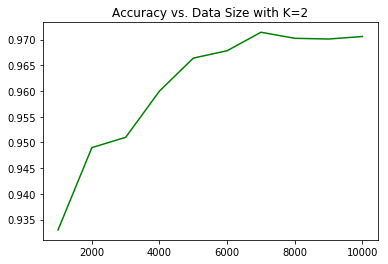

[0.92700000000000005, 0.95350000000000001, 0.96033333333333337, 0.96825000000000006, 0.96999999999999997, 0.97150000000000003, 0.97328571428571431, 0.97350000000000003, 0.97399999999999998, 0.97460000000000002]


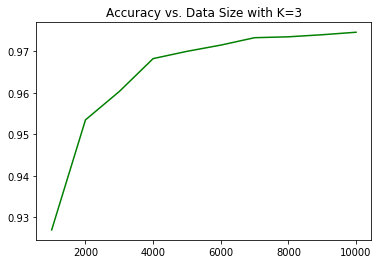

In [7]:
data = Numbers("../data/mnist.pklz")
data_size = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
k = 2
accuracyList = [0, 0, 0 ,0, 0, 0, 0, 0, 0, 0]
index = 0
for size in data_size:
    knn = Knearest(data.train_x[:size], data.train_y[:size], k)
    C = knn.confusion_matrix(data.train_x[:size], data.train_y[:size])
    accurate = knn.accuracy(C)
    accuracyList[index] = accurate
    index+=1
print(accuracyList)
plt.title("Accuracy vs. Data Size with K=2")
plt.plot(data_size, accuracyList, color='g')
plt.show()

data_size = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
k = 3
accuracyList = [0, 0, 0 ,0, 0, 0, 0, 0, 0, 0]
index = 0
for size in data_size:
    knn = Knearest(data.train_x[:size], data.train_y[:size], k)
    C = knn.confusion_matrix(data.train_x[:size], data.train_y[:size])
    accurate = knn.accuracy(C)
    accuracyList[index] = accurate
    index+=1
print(accuracyList)
plt.title("Accuracy vs. Data Size with K=3")
plt.plot(data_size, accuracyList, color='g')
plt.show()


**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 


Initially, my data size was 7000 and the accuracy for k = 1 was 1.0, k=2 was 0.9714, and k = 3 gave an accuracy of 0.9733.
I changed my data size to 10,000 and for k = 1 the accuracy was 1.0, k = 2 was 0.9706 , and k = 3 gave an accuracy of 0.9746. 

It seems that the least accurate k value was 2. Reasons for this can include that when we have two options to classify an image, 
we base our classification on the highest label from the self._counts dictionary. While this is more accurate than picking a 
random classification from the two labels, it still provides a higher chance of error compared to k = 1 or k = 3. 
When k = 3, ties are initially broken when a label occurs twice in the frequency label and we do not have to resort to 
self._counts dictionary to pick the highest label from the training set. It provides better accuracy than an even k value. 
Finally, k = 1 gives the best accuracy of 1.0 because it classifies an image based on the closest neighbor sorted through 
BallTree().


In [9]:
import unittest
import numpy as np
from sklearn.neighbors import BallTree
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pickle, gzip
import random
from collections import Counter

class Numbers:
    def __init__(self, location):
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

class Knearest:
    """
    kNN classifier
    """
    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance
        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self): 
        dictionary = { }
        for labels in self._y:
            if labels not in dictionary:
                dictionary[labels] = 0
            dictionary[labels] += 1

        return dictionary

    def majority(self, neighbor_indices):
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"

        neighbor_labels = [self._y[i] for i in neighbor_indices] #given indices, grab the corresponding labels from self._y
        
        labels_frequency = { }
        for labels in neighbor_labels:
            if labels not in labels_frequency:
                labels_frequency[labels] = 0
            labels_frequency[labels] += 1
            
        maximum = max(labels_frequency, key = labels_frequency.get)
        maximum_label = 0

        if labels_frequency[maximum] == 1:
            for x in labels_frequency:
                if self._counts[x] > maximum_label:
                    maximum_label = self._counts[x]
                    maximum = x

        return maximum
    
    def classify(self, example):
        dist, ind = self._kdtree.query(np.array(example).reshape(1, -1), k=self._k)
        return self.majority(ind[0])

    def confusion_matrix(self, test_x, test_y):
        C = np.zeros((10,10), dtype=int)
        picture_index = 0
        for xx, yy in zip(test_x, test_y):
            jj = self.classify(xx) #return the predicted label
            C[yy][jj] += 1 #increase by 1 where true label and predicted label intersect
            
            '''if jj == 5 and picture_index < 5:
                plt.imshow(xx.reshape((28, 28)), cmap=cm.Greys_r)
                plt.show()
                picture_index+=1'''

        #print(C)
        return C 
            
    @staticmethod
    def accuracy(C):
        return np.sum(C.diagonal()) / C.sum()
    
    def view_digit(example, label=None):
        if label: print("true label: {:d}".format(label))
        plt.imshow(example.reshape(28,28), cmap='gray');


[1.0, 0.97142857142857142, 0.97328571428571431]


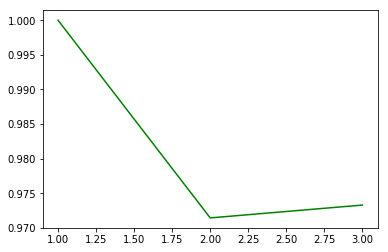

[1.0, 0.97060000000000002, 0.97460000000000002]


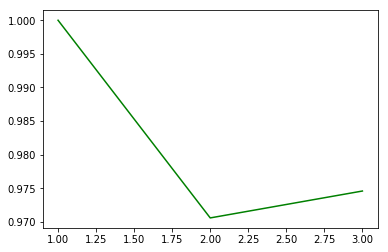

In [10]:
data = Numbers("../data/mnist.pklz")
data_size = [7000, 10000]
k = [1,2,3]
accuracyList = [0, 0, 0]
index = 0
for size in data_size:
    for x in k:
        knn = Knearest(data.train_x[:size], data.train_y[:size], x)
        C = knn.confusion_matrix(data.train_x[:size], data.train_y[:size])
        accurate = knn.accuracy(C)
        accuracyList[index] = accurate
        index+=1
    index = 0
    print(accuracyList)
    plt.plot(k, accuracyList, color='g')
    plt.show()

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  


Based on my program, the number that had the lowest accuracy and highest confusion was 5. When I plotted several examples 
that had 5 in them, it made sense. The code below has a set of only 250 images, I knew beforehand that 5 was the most confused
number when I ran the program with k = 3 with a data set of 50,000 images, as a result, the code below will serve the purpose of
showing those images and prints out the confusion matrix as well.

5 is written in various ways, in some images, it can be regarded as a 6 instead of a 5, and in some rare situations even a 2 or
an 8, this can be due to cursive handwriting which confuses the program when classifying the image. 


In [11]:
import unittest
import numpy as np
from sklearn.neighbors import BallTree
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pickle, gzip
import random
from collections import Counter

class Numbers:
    def __init__(self, location):
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

class Knearest:
    """
    kNN classifier
    """
    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance
        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self): 
        dictionary = { }
        for labels in self._y:
            if labels not in dictionary:
                dictionary[labels] = 0
            dictionary[labels] += 1

        return dictionary

    def majority(self, neighbor_indices):
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"

        neighbor_labels = [self._y[i] for i in neighbor_indices] #given indices, grab the corresponding labels from self._y
        
        labels_frequency = { }
        for labels in neighbor_labels:
            if labels not in labels_frequency:
                labels_frequency[labels] = 0
            labels_frequency[labels] += 1
            
        maximum = max(labels_frequency, key = labels_frequency.get)
        maximum_label = 0

        if labels_frequency[maximum] == 1:
            for x in labels_frequency:
                if self._counts[x] > maximum_label:
                    maximum_label = self._counts[x]
                    maximum = x

        return maximum
    
    def classify(self, example):
        dist, ind = self._kdtree.query(np.array(example).reshape(1, -1), k=self._k)
        return self.majority(ind[0])

    def confusion_matrix(self, test_x, test_y):
        C = np.zeros((10,10), dtype=int)
        picture_index = 0
        print("doing confusion stuff")
        for xx, yy in zip(test_x, test_y):
            jj = self.classify(xx) #return the predicted label
            C[yy][jj] += 1 #increase by 1 where true label and predicted label intersect
            
            if jj == 5 and picture_index < 5:
                plt.imshow(xx.reshape((28, 28)), cmap=cm.Greys_r)
                plt.show()
                picture_index+=1

        print(C)
        return C 
            
    @staticmethod
    def accuracy(C):
        return np.sum(C.diagonal()) / C.sum()
    
    def view_digit(example, label=None):
        if label: print("true label: {:d}".format(label))
        plt.imshow(example.reshape(28,28), cmap='gray');

doing confusion stuff


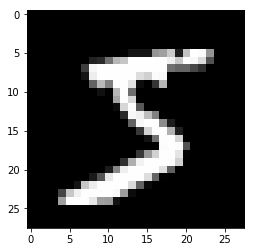

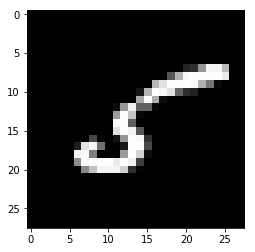

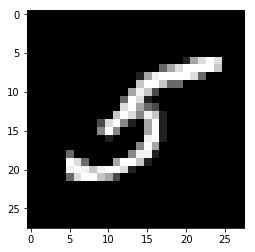

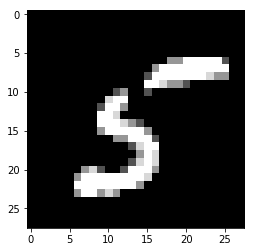

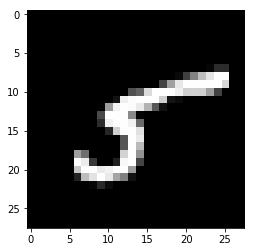

In [ ]:
data = Numbers("../data/mnist.pklz")
'''
Two Tests, one with x = 50,000 and k = 3 to compute the confusion matrix. Another with x = 250 and k = 3 just to print out the
images. Note, I did not use the function provided to print out the images. 
'''
x = 50000
knn = Knearest(data.train_x[:x], data.train_y[:x], 3)
C = knn.confusion_matrix(data.train_x[:x], data.train_y[:x])
accurate = knn.accuracy(C)

x = 250
knn = Knearest(data.train_x[:x], data.train_y[:x], 3)
C = knn.confusion_matrix(data.train_x[:x], data.train_y[:x])
accurate = knn.accuracy(C)